In [1]:
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
from glob import glob
import struct
from scipy.optimize import curve_fit

def load_waveforms_until_eof(
    path,
    *,
    channels=4,
    samples_per_waveform=500,
    dtype="<f4",          # little-endian float32
    event_header_bytes=28 # set to 0 if there's no per-event header
):
    """
    Reads events until EOF.
    Each event layout: [event_header_bytes] + [channels * samples_per_waveform * dtype]
    Returns:
      waveforms: (num_events, channels, samples_per_waveform) array
      headers:   (num_events, event_header_bytes//4) <u4 array (or None if header_bytes==0)
    """
    path = Path(path)
    sample_bytes = np.dtype(dtype).itemsize
    data_bytes_per_event = channels * samples_per_waveform * sample_bytes

    wfs = []
    hdrs = [] if event_header_bytes else None
    event_times = [] if hdrs is not None else None

    with path.open("rb") as f:
        evt = 0
        while True:
            # Read per-event header (if any)
            if event_header_bytes:
                h = f.read(event_header_bytes)
                if not h:
                    break  # clean EOF at boundary
                if len(h) != event_header_bytes:
                    print(f"Warning: partial header at event {evt} — stopping.")
                    break
                if event_header_bytes >= 12:
                    event_id = struct.unpack("<I", h[0:4])[0]
                    event_time = struct.unpack("<Q", h[4:12])[0]
            else:
                # If no header, peek one byte to see if we're at EOF
                p = f.peek(1) if hasattr(f, "peek") else f.read(1)
                if p == b"":
                    break
                if not hasattr(f, "peek"):
                    # we consumed 1 byte; seek back
                    f.seek(-1, 1)

            # Read waveform payload
            buf = f.read(data_bytes_per_event)
            if len(buf) != data_bytes_per_event:
                print(f"Warning: partial data payload at event {evt} — stopping.")
                break

            arr = np.frombuffer(buf, dtype=dtype).reshape(channels, samples_per_waveform)
            wfs.append(arr)
            event_times.append(event_time) if hdrs is not None else None
            evt += 1

    if not wfs:
        raise RuntimeError("No complete events found.")

    waveforms = np.stack(wfs, axis=0)  # (E, C, N)
    # headers = (np.stack(hdrs, axis=0) if hdrs is not None else None)
    return waveforms, event_times



/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
run         = 'Run22'
run_dir     = f"/home/marian/CIGAR_ANALYSIS/CIGAR/data/{run}"

nchannels       = 10
nevents_per_wvf = 500

samples_per_waveform = 752

event_header_bytes = 28
# event_header_bytes = 3036

# sample_binning = 1
sample_binning = 8e-9

nfiles = 10

fixBaselines_noAmp = {'CH1': -369.89
                      ,'CH2': -410.61
                      ,'CH3': -350.80
                      ,'CH4': -408.68
                      }
fixBaselines_Amp = {'CH1': -485.60
                    ,'CH2': -486.59
                    ,'CH3': -485.52
                    ,'CH4': -485.15
                    }

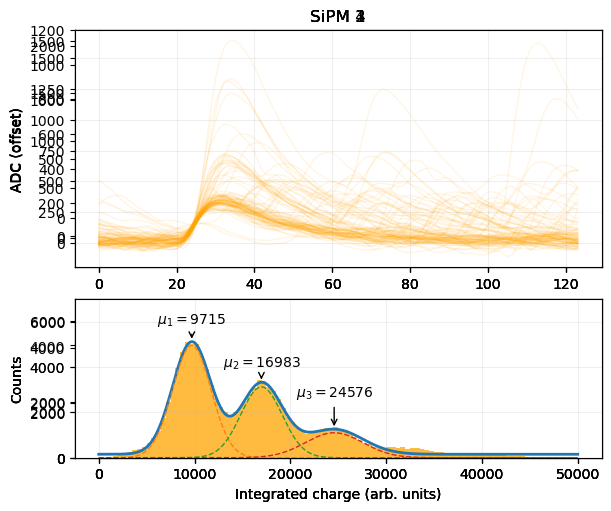

In [3]:


# --------------------
# Config
# --------------------
channels = [1, 2, 3, 4]
colors   = ['blue', 'red', 'green', 'orange']
base     = "/home/marian/CIGAR_ANALYSIS/CIGAR/data/"
offset   = 600
charge_slice = slice(20, 100)   # integrate samples 20:100
bins     = 100
charge_range = (0, 50000)

# Triple-Gaussian (+ constant baseline) model for SiPM finger plot
def triple_gauss(x, A1, mu1, s1, A2, mu2, s2, A3, mu3, s3, C):
    g1 = A1 * np.exp(-0.5*((x - mu1)/s1)**2)
    g2 = A2 * np.exp(-0.5*((x - mu2)/s2)**2)
    g3 = A3 * np.exp(-0.5*((x - mu3)/s3)**2)
    return g1 + g2 + g3 + C

fig = plt.figure(figsize=(12, 10), constrained_layout=True)
outer = fig.add_gridspec(2, 2, hspace=0.3, wspace=0.2)
peak_means = {}      # ch -> np.array([mu1, mu2, mu3])
peak_errors = {}
for i, (ch, color) in enumerate(zip(channels, colors)):
    # Load waveforms for this channel
    files = glob(f"{base}/Run20SPheCH{ch}/*.bin")
    wfs_list = [load_waveforms_until_eof(f, channels=1, samples_per_waveform=124, event_header_bytes=28)[0]
                for f in files]
    times_list = [load_waveforms_until_eof(f, channels=1, samples_per_waveform=124, event_header_bytes=28)[1]
                  for f in files]
    times = np.concatenate(times_list, axis=0)
    wfs = np.concatenate(wfs_list, axis=0)  # shape: (N, 1, 124)

    # Subgrid: independent x-axes (do NOT share x between top and bottom)
    r, c = divmod(i, 2)
    sub = outer[r, c].subgridspec(2, 1, height_ratios=[3, 2], hspace=0.)
    ax_top = fig.add_subplot(sub[0])
    ax_bot = fig.add_subplot(sub[1])

    # ---- Top: waveforms ----
    nshow = min(100, len(wfs))
    for j in range(nshow):
        ax_top.plot(wfs[j, 0] + offset, color=color, alpha=0.1, linewidth=1)
    ax_top.set_title(f"SiPM {ch}")
    ax_top.set_ylabel("ADC (offset)")
    ax_top.grid(alpha=0.2)

    # ---- Bottom: charge spectrum + triple-Gaussian fit ----
    charge = np.trapz(wfs[:, 0, charge_slice] + offset, axis=1)

    counts, edges = np.histogram(charge, bins=bins, range=charge_range)
    centers = 0.5 * (edges[:-1] + edges[1:])  # Correctly compute bin centers
    ax_bot.hist(charge, bins=bins, range=charge_range, color=color, alpha=0.75, label="Data")
    ax_bot.set_ylabel("Counts")
    ax_bot.set_xlabel("Integrated charge (arb. units)")
    ax_bot.grid(alpha=0.2)

    # Initial guesses and bounds for the three peaks
    # Seed near ~10k, ~17k, and ~24k (adjustable); widths ~800; amplitudes ~max count.
    A_guess = max(counts) if len(counts) else 100.0
    p0 = [
        0.8*A_guess, 10000.0, 800.0,
        0.6*A_guess, 17000.0, 900.0,
        0.4*A_guess, 24000.0, 1000.0,
        0.0  # constant baseline
    ]
    # Reasonable bounds to stabilize the fit
    lower = [
        0.0,  8000.0,  200.0,
        0.0, 15000.0,  200.0,
        0.0, 20000.0,  200.0,
        -np.inf
    ]
    upper = [
        np.inf, 13000.0, 3000.0,
        np.inf, 20000.0, 3000.0,
        np.inf, 30000.0, 3000.0,
        np.inf
    ]

    # Fit
    try:
        popt, pcov = curve_fit(triple_gauss, centers, counts, p0=p0, bounds=(lower, upper), maxfev=20000)
        fit_x = np.linspace(charge_range[0], charge_range[1], 2000)
        fit_y = triple_gauss(fit_x, *popt)
        ax_bot.plot(fit_x, fit_y, linewidth=2, label="3-Gauss fit")

        # Plot individual Gaussians for clarity
        A1, mu1, s1, A2, mu2, s2, A3, mu3, s3, C = popt
        g1 = A1 * np.exp(-0.5*((fit_x - mu1)/s1)**2) + 0.0
        g2 = A2 * np.exp(-0.5*((fit_x - mu2)/s2)**2) + 0.0
        g3 = A3 * np.exp(-0.5*((fit_x - mu3)/s3)**2) + 0.0
        ax_bot.plot(fit_x, g1, linestyle="--", linewidth=1)
        ax_bot.plot(fit_x, g2, linestyle="--", linewidth=1)
        ax_bot.plot(fit_x, g3, linestyle="--", linewidth=1)
        perr = np.sqrt(np.diag(pcov))
        mu1_err, mu2_err, mu3_err = perr[1], perr[4], perr[7]
        # Annotate the peak positions
        ax_bot.annotate(fr"$\mu_1 = {mu1:.0f}$", xy=(mu1, triple_gauss(mu1, *popt)), xytext=(mu1, ax_bot.get_ylim()[1]*1.1),
                        arrowprops=dict(arrowstyle='->', lw=1), ha='center')
        ax_bot.annotate(fr"$\mu_2 = {mu2:.0f}$", xy=(mu2, triple_gauss(mu2, *popt)), xytext=(mu2, ax_bot.get_ylim()[1]*0.75),
                        arrowprops=dict(arrowstyle='->', lw=1), ha='center')
        ax_bot.annotate(fr"$\mu_3 = {mu3:.0f}$", xy=(mu3, triple_gauss(mu3, *popt)), xytext=(mu3, ax_bot.get_ylim()[1]*0.5),
                        arrowprops=dict(arrowstyle='->', lw=1), ha='center')
        ax_bot.set_ylim(top=ax_bot.get_ylim()[1]*1.3)  # Add some headroom for annotations
        peak_means[ch]  = np.array([mu1, mu2, mu3])
        peak_errors[ch] = np.array([mu1_err, mu2_err, mu3_err])
        # ax_bot.legend(loc="upper right", fontsize=8)
    except Exception as e:
        # If the fit fails, keep the histogram and note it
        ax_bot.text(0.02, 0.95, f"Fit failed: {e}", transform=ax_bot.transAxes, va='top', ha='left', fontsize=8)

# fig.suptitle("SiPM Waveform Calibration (55 bar Xe) — Waveforms + 3-Gaussian Finger Fits", fontsize=14)
plt.show()

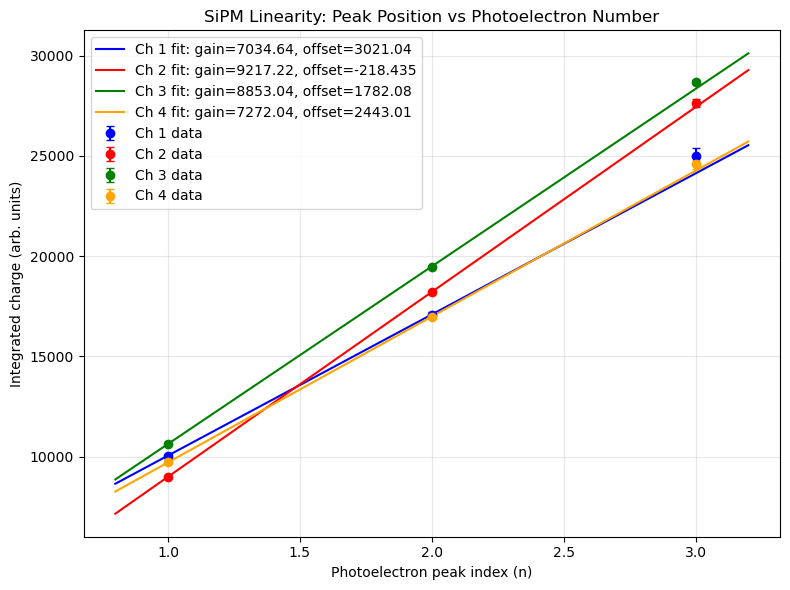

In [4]:
fig, ax = plt.subplots(figsize=(8, 6))
n_pe = np.array([1, 2, 3])

gains = []
offsets = []

for ch, color in zip(channels, colors):
    y = peak_means[ch]
    yerr = peak_errors[ch]

    # Weighted linear fit (optional: use 1/σ^2 as weights if not zero)
    w = np.where(yerr > 0, 1.0 / (yerr**2), 1.0)
    # Fit y = a*n_pe + b
    # Use np.polyfit with weights -> since NumPy 1.22 supports 'w' argument
    a, b = np.polyfit(n_pe, y, 1, w=w)

    xfit = np.linspace(0.8, 3.2, 200)
    yfit = a * xfit + b
    yhat = a * n_pe + b
    gains.append(a)
    offsets.append(b)

    ax.errorbar(n_pe, y, yerr=yerr, fmt='o', capsize=3, label=f"Ch {ch} data", color=color)
    ax.plot(xfit, yfit, linestyle='-', linewidth=1.5, color=color,
            label=f"Ch {ch} fit: gain={a:g}, offset={b:g}")

ax.set_xlabel("Photoelectron peak index (n)")
ax.set_ylabel("Integrated charge (arb. units)")
ax.set_title("SiPM Linearity: Peak Position vs Photoelectron Number")
ax.grid(alpha=0.3)
ax.legend()
plt.tight_layout()
plt.show()

Run duration: 634.946911401 s


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


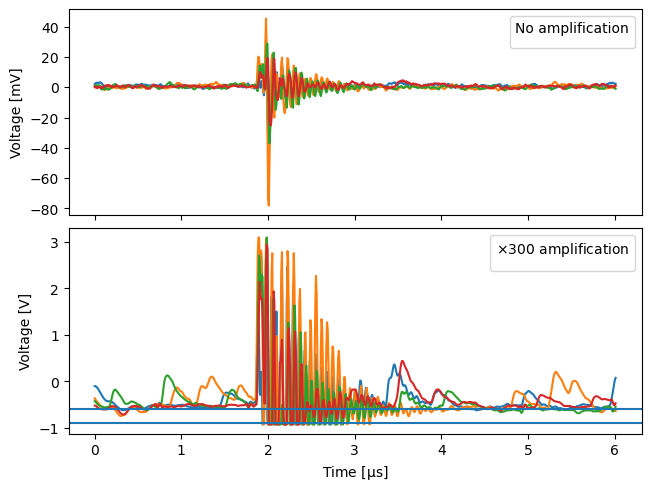

In [5]:

wfs = []
times = []

for f in glob(f"{run_dir}/*.bin"):
    wf, ts = load_waveforms_until_eof(f, channels=10, samples_per_waveform=752, event_header_bytes=28)
    wfs.append(wf)
    times.extend(ts)

run_duration_with_ba133 = max(times) - min(times)
print(f"Run duration: {run_duration_with_ba133/1e9} s")

wfs_a = np.concatenate(wfs)
integrals = []
integrals_no_cosmic = []

amplified_channels = [3,5,7,9]
not_amplified_channels = [2,4,6,8]
not_amplified_offsets = [370, 410, 350, 409]
# fig, ax = plt.subplots(2,1)
time_ticks = np.linspace(0, 6.012, 752)
# ax.plot(wf[0][0])
for i in range(1):
    # if np.min(wfs[0][i][0]) > 150 and np.max(wfs[0][i][0]) > 350 and np.min(wfs[0][i][1])+600 > -100:
    # print(i,wfs[0].shape[0])
    fig, ax = plt.subplots(2,1, sharex=True, constrained_layout=True)
    # integrals_no_cosmic.append(np.sum(wfs[0][i][0]))
    # ax[0].plot(wfs[0][i][0], color='gray', alpha=1, label='Scintillator panel')
    # ax[1].plot(wfs[0][i][1]+600, color='blue', alpha=1, label='SiPM 1 CIGAR')
    # ax[1].plot(wfs[0][i][2]+600, color='orange', alpha=1, label='SiPM 2 CIGAR')
    for m,k in enumerate(not_amplified_channels):
        ax[0].plot(time_ticks, wfs_a[i][k]+not_amplified_offsets[m], alpha=1)
        # ax[0].plot(wfs[0] /[i][3]+600, color='green', alpha=1, label='SiPM 3 CIGAR')
        # break
    for j in amplified_channels:
        ax[1].plot(time_ticks, wfs_a[i][j]/1e3, alpha=1)
        # ax[1].plot(wfs[0] /[i][6]+600, color='red', alpha=1, label='SiPM 4 CIGAR')
        # break
# ax[0].axhline(300)
# ax[0].set_xlim(200,400)
ax[1].set_xlabel('Time [$\mathrm{\mu}$s]')
ax[1].set_ylabel('Voltage [V]')
ax[0].set_ylabel('Voltage [mV]')
ax[0].legend(title='No amplification')
ax[1].legend(title=r'$\times300$ amplification')
ax[1].axhline(-0.600)
fig.savefig("wfs_xe.pdf")
# ax[1].axvline(220, color='red', linestyle='--')
ax[1].axhline(-900*1e-3)
# ax[1].set_xticks(np.arange(100, 0, 6.012))
# ax[1].set_xticklabels(np.arange(10, 0, 6.012))

In [6]:
a = [1, 2, 3, 4]

In [7]:
a[slice(2)]

[1, 2]

In [8]:
slice(220)


slice(None, 220, None)

In [9]:
np.array(not_amplified_offsets) - np.array([369, 410, 350, 408])

array([1, 0, 0, 1])

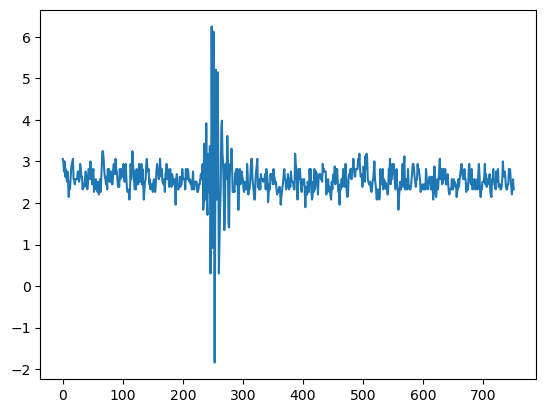

In [10]:
plt.plot((wfs_a[0][0]))

In [11]:
np.shape(wfs_a)

(48500, 10, 752)

In [12]:
np.min(wfs_a, axis=(1, 2))

array([-925.16565, -754.6168 , -724.5622 , ..., -756.38324, -740.4482 ,
       -782.3407 ], dtype=float32)

In [13]:

# mask = np.min(wfs_a, axis=(1, 2)) > -900
mask = np.min(wfs_a, axis=(1, 2)) > -800
wfs_filtered = wfs_a[mask]
not_amplified_offsets = [369, 410, 350, 408]
# not_amplified_offsets = [-fixBaselines_Amp['CH1'], 
#                          -fixBaselines_Amp['CH2'], 
#                          -fixBaselines_Amp['CH3'], 
#                          -fixBaselines_Amp['CH4'] 
#                          ]
amp_offset = 600

integration_window = slice(220,400)
amplified_integral_1_with = (np.trapz(wfs_filtered[:, amplified_channels[0], integration_window]+amp_offset, axis=(1)))
amplified_integral_2_with = (np.trapz(wfs_filtered[:, amplified_channels[1], integration_window]+amp_offset, axis=(1)))
amplified_integral_3_with = (np.trapz(wfs_filtered[:, amplified_channels[2], integration_window]+amp_offset, axis=(1)))
amplified_integral_4_with = (np.trapz(wfs_filtered[:, amplified_channels[3], integration_window]+amp_offset, axis=(1)))

not_amplified_integral_1_with = (np.trapz(wfs_filtered[:, not_amplified_channels[0], integration_window]+not_amplified_offsets[0], axis=(1)))
not_amplified_integral_2_with = (np.trapz(wfs_filtered[:, not_amplified_channels[1], integration_window]+not_amplified_offsets[1], axis=(1)))
not_amplified_integral_3_with = (np.trapz(wfs_filtered[:, not_amplified_channels[2], integration_window]+not_amplified_offsets[2], axis=(1)))
not_amplified_integral_4_with = (np.trapz(wfs_filtered[:, not_amplified_channels[3], integration_window]+not_amplified_offsets[3], axis=(1)))

amplified_amplitude_1_with = (np.max(wfs_filtered[:, amplified_channels[0], :], axis=1) + amp_offset)
amplified_amplitude_2_with = (np.max(wfs_filtered[:, amplified_channels[1], :], axis=1) + amp_offset)
amplified_amplitude_3_with = (np.max(wfs_filtered[:, amplified_channels[2], :], axis=1) + amp_offset)
amplified_amplitude_4_with = (np.max(wfs_filtered[:, amplified_channels[3], :], axis=1) + amp_offset)

not_amplified_amplitude_1_with = (np.max(wfs_filtered[:, not_amplified_channels[0], :], axis=1) + not_amplified_offsets[0])
not_amplified_amplitude_2_with = (np.max(wfs_filtered[:, not_amplified_channels[1], :], axis=1) + not_amplified_offsets[1])
not_amplified_amplitude_3_with = (np.max(wfs_filtered[:, not_amplified_channels[2], :], axis=1) + not_amplified_offsets[2])
not_amplified_amplitude_4_with = (np.max(wfs_filtered[:, not_amplified_channels[3], :], axis=1) + not_amplified_offsets[3])

# ax.set_yscale('log')

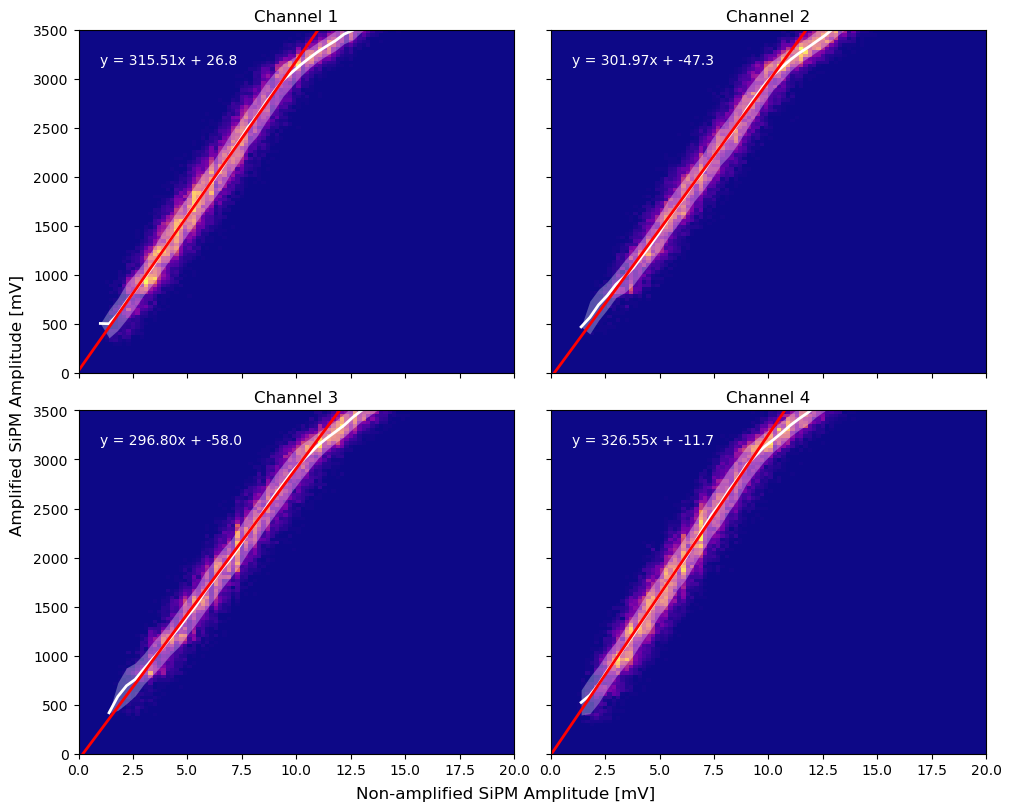

: 

In [ ]:
from scipy.stats import binned_statistic

# --- Group your channels for easy looping ---
not_amplified = [
    not_amplified_amplitude_1_with,
    not_amplified_amplitude_2_with,
    not_amplified_amplitude_3_with,
    not_amplified_amplitude_4_with
]

amplified = [
    amplified_amplitude_1_with,
    amplified_amplitude_2_with,
    amplified_amplitude_3_with,
    amplified_amplitude_4_with
]

titles = [f"Channel {i+1}" for i in range(4)]

# --- Figure setup ---
fig, axs = plt.subplots(2, 2, figsize=(10, 8), sharex=True, sharey=True, constrained_layout=True)
axs = axs.ravel()

# --- Common settings ---
bins = 50
xrange = (0, 20)
yrange = (0, 3500)
# xrange = (50, 200)
# yrange = (500, 4000)
fit_range = (2.5, 10)

fee_coeffs = {}

# --- Loop over channels ---
for i in range(4):
    ax = axs[i]
    x = not_amplified[i]
    y = amplified[i]
    
    # 2D histogram
    h, xedges, yedges, im = ax.hist2d(
        x, y, bins=100, range=[xrange, yrange], cmap='plasma'
    )
    
    # Mean profile
    mean, xedges, _ = binned_statistic(x, y, statistic='mean', bins=bins, range=xrange)
    std, _, _ = binned_statistic(x, y, statistic='std', bins=bins, range=xrange)
    xcenters = 0.5 * (xedges[1:] + xedges[:-1])

    # Overlay mean ± std
    ax.plot(xcenters, mean, color='white', lw=2, label='Mean profile')
    ax.fill_between(xcenters, mean-std, mean+std, color='white', alpha=0.3, lw=0)

    # Fit (linear in restricted range)
    mask = (xcenters > fit_range[0]) & (xcenters < fit_range[1]) & np.isfinite(mean)
    if np.count_nonzero(mask) > 2:
        coeffs = np.polyfit(xcenters[mask], mean[mask], deg=1)
        p = np.poly1d(coeffs)
        fee_coeffs[i] = coeffs
        xfit = np.linspace(xrange[0], xrange[1], 400)
        yfit = p(xfit)
        ax.plot(xfit, yfit, 'r-', lw=2, label='Linear fit')
        ax.text(0.05, 0.9, f"y = {coeffs[0]:.2f}x + {coeffs[1]:.1f}", color='w', transform=ax.transAxes)

    # Labels and formatting
    ax.set_title(titles[i])
    ax.set_xlim(*xrange)
    ax.set_ylim(*yrange)

# --- Global labels ---
fig.supxlabel("Non-amplified SiPM Amplitude [mV]")
fig.supylabel("Amplified SiPM Amplitude [mV]")

plt.show()